In [10]:

%reset
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/mocsy-master')
import mocsy
import xarray as xr
import glob
import numpy as np
import netCDF4 as nc
import warnings
import matplotlib.path as mpath
import cartopy.feature as cfeature

warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from cmocean import cm
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/')
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/')
import scendict as sc
import utils as ut


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [11]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


# Driver analysis of the pCO2 cycle in several model versions

Based on observations, we expect the seasonal cycle of pCO2 to attain lowest value in austral summer (DJF), and for this season to be the season of highest net ingassing. What we get is the opposite, and we want to know why. 

Mongwe et al did some analysis of this Southern Ocean pco2 seasonality in the CMIP6 models and the various troubles they run into. Fig S1 shows the rough observations we are aiming at: 

https://bg.copernicus.org/articles/15/2851/2018/bg-15-2851-2018-supplement.pdf

note - read-off-graph in that supplement of gregor 2017 (red line, antarctic zone as defined by mckinley 2014, 1998-2011):





Text(0.5, 1.0, 'pco2 (uatm) obs. seas. cycle \n Antarctic zone, 1998-2011 (McKinley 2014) \n approximated from gregor 2017 in Mongwe 2018, red line Fig S1')

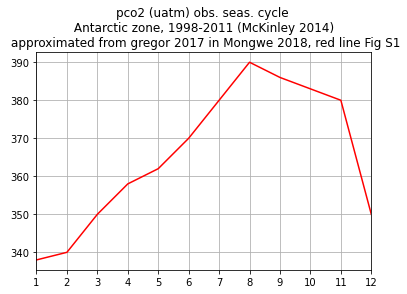

In [12]:
mo = np.arange(1,13,1)
pco2_gregor17 = np.array([338, 340, 350, 358, 362, 370, 380, 390, 386, 383, 380, 350])
plt.plot(mo,pco2_gregor17, color = 'r')
q =plt.xticks(np.arange(1,13,1))
plt.grid()
plt.xlim([1,12])
plt.title('pco2 (uatm) obs. seas. cycle \n Antarctic zone, 1998-2011 (McKinley 2014) \n approximated from gregor 2017 in Mongwe 2018, red line Fig S1')

pco2 is a non-conservative quantity of the calcium carbonate system, chiefly depending on the two carbonate species TA, DIC, on T, pressure, and (slightly) S. As we see here:
https://nbviewer.org/github/tjarnikova/SOZONE/blob/master/SOpCO2Cycle/pco2mocsy.ipynb

- for a given T, S, as TA-DIC goes up, pco2 goes down (monotonically but nonlinearly)
- at a given TA-DIC, as T goes up, pco2 goes up (basically linearly, rates increase as TA-DIC goes down)

### Here are some simplified back-of-envelope-calculations:

- pco2 increases *linearly* with temperature at a given TA-DIC (rate of increase depends on TA-DIC, at low TA-DIC, pco2 increase is larger)
- pco2 decreases *nonlinearly* with TA-DIC - but at a given TA-DIC, temperature is less important 
- pco2 changes with salinity are universally very low (pco2 increases with salt)


In [13]:
#salinity 30, temperature 10 , DIC AND TA vary from 1800 to 2200 

#salinity 0-35
def gimme_pco2mesh_TADIC(DIC,TA,S,T):

    Sr = np.ravel(S)
    Tr = np.ravel(T)  
    DICr = np.ravel(DIC) * 1e-3
    TAr = np.ravel(TA) * 1e-3

    zero = DICr *0
    patm1 = zero+1
    tlat = zero+-60

    response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=patm1, depth=zero, lat=tlat, 
                        optcon='mol/m3', optt='Tinsitu', optp='db',
                        optb = 'u74', optk1k2='m10', optkf = 'pf', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup


    return pco2

def gimme_pco2point(DIC,TA,S,T, verbose = True):

    Sr = np.ravel(S)
    Tr = np.ravel(T)  
    DICr = np.ravel(DIC) * 1e-3
    TAr = np.ravel(TA) * 1e-3

    zero = DICr *0
    patm1 = zero+1
    tlat = zero+-60

    response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=patm1, depth=zero, lat=tlat, 
                        optcon='mol/m3', optt='Tinsitu', optp='db',
                        optb = 'u74', optk1k2='m10', optkf = 'pf', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
    
    if verbose:
        print(f'pco2 {pco2[0]} (DIC {DIC}umol/L, TA: {TA}umol/L, S: {Sr} psu, T: {Tr} degC)')
    #print(f'pco2 {pco2[0]}')

    return pco2[0]



Text(0.5, 0.98, 'pco2 sensitivity to temperature and TA-DIC changes')

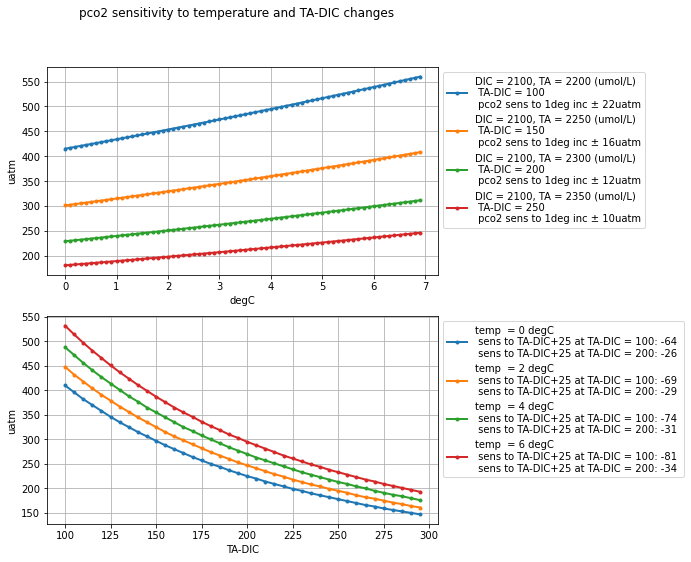

In [14]:
tdic = 2100
fact = 0.7
fig, axs = plt.subplots(2,1, figsize=(10*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for deldic in range(100,300,50):
    Ts = np.arange(0,7,0.1)
    ta = tdic + deldic
    DICs = np.zeros_like(Ts); DICs[:] = tdic
    TAs = DICs + deldic
    Ss = np.zeros_like(Ts); Ss[:] = 34.5
    pco2s = np.zeros_like(Ts)
    for i in range(0,len(pco2s)):
        pco2s[i] = gimme_pco2point(DICs[i],TAs[i],Ss[i],Ts[i], verbose = False)

    sens = (pco2s[60]-pco2s[50])
    tlab = f'DIC = {tdic}, TA = {ta} (umol/L) \n TA-DIC = {ta-tdic} \n pco2 sens to 1deg inc ± {int(sens)}uatm' 
    axs[0].plot(Ts, pco2s, marker = '.', linewidth = 2, label = tlab)
    axs[0].legend(bbox_to_anchor = [1,1])
    axs[0].set_xlabel('degC')
    
for temp in range(0,8,2):
    TADIC = np.arange(100,300,5)
    DICs = np.zeros_like(TADIC); DICs[:] = tdic
    TAs = DICs + TADIC
    Ss = np.zeros_like(TADIC); Ss[:] = 34.5
    Ts = np.zeros_like(TADIC); Ts[:] = temp
    pco2s = np.zeros_like(Ts)
    for i in range(0,len(pco2s)):
        pco2s[i] = gimme_pco2point(DICs[i],TAs[i],Ss[i],Ts[i], verbose = False)

    sens1 = (pco2s[5]-pco2s[0])
    sens2 = (pco2s[25]-pco2s[20])
    tlab = f'temp  = {temp} degC \n sens to TA-DIC+25 at TA-DIC = 100: {sens1} \n sens to TA-DIC+25 at TA-DIC = 200: {sens2}' 
    axs[1].plot(TADIC, pco2s, marker = '.', linewidth = 2, label = tlab)
    axs[1].legend(bbox_to_anchor = [1,1])
    axs[1].set_xlabel('TA-DIC')
    
for i in range(0,2):
    axs[i].grid()
    axs[i].set_ylabel('uatm')
    
plt.suptitle('pco2 sensitivity to temperature and TA-DIC changes')

Text(0.5, 0.98, 'pco2 sensitivity to salinity changes')

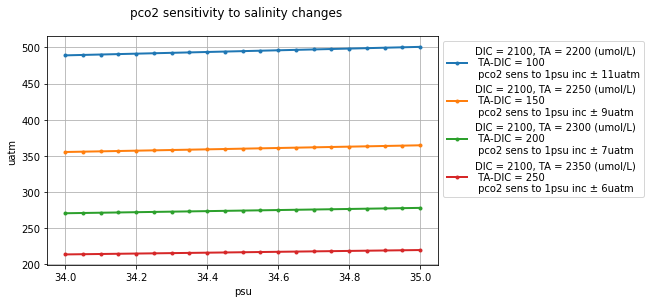

In [15]:
tdic = 2100
fact = 0.7
fig, axs = plt.subplots(1,1, figsize=(10*fact, 6*fact), facecolor='w', edgecolor='k')

for deldic in range(100,300,50):
    Ss = np.arange(34,35.05,0.05)
    ta = tdic + deldic
    DICs = np.zeros_like(Ss); DICs[:] = tdic
    TAs = DICs + deldic
    Ts = np.zeros_like(Ss); Ts[:] = 4
    pco2s = np.zeros_like(Ts)
    for i in range(0,len(pco2s)):
        pco2s[i] = gimme_pco2point(DICs[i],TAs[i],Ss[i],Ts[i], verbose = False)

    sens = (pco2s[20]-pco2s[0])
    tlab = f'DIC = {tdic}, TA = {ta} (umol/L) \n TA-DIC = {ta-tdic} \n pco2 sens to 1psu inc ± {int(sens)}uatm' 
    axs.plot(Ss, pco2s, marker = '.', linewidth = 2, label = tlab)
    axs.legend(bbox_to_anchor = [1,1])
    axs.set_xlabel('psu')
    

    
for i in range(0,1):
    axs.grid()
    axs.set_ylabel('uatm')
    
plt.suptitle('pco2 sensitivity to salinity changes')

In [16]:
print('point check:')
DIC = 2200; TA = 2300; S = 32; T = 2
print(f'**** DIC {DIC}umol/L, TA: {TA}umol/L, S: {S} psu, T: {T} degC')
degdif = 1
T1 = gimme_pco2point(DIC,TA,S,T)
T2 = gimme_pco2point(DIC,TA,S,T+degdif)
print(f'sensitivity of pco2 to {degdif} deg C here: {T2-T1}')
print('')



point check:
**** DIC 2200umol/L, TA: 2300umol/L, S: 32 psu, T: 2 degC
pco2 455.7073454065345 (DIC 2200umol/L, TA: 2300umol/L, S: [32] psu, T: [2] degC)
pco2 476.2192418307371 (DIC 2200umol/L, TA: 2300umol/L, S: [32] psu, T: [3] degC)
sensitivity of pco2 to 1 deg C here: 20.511896424202575




### In summer, the main processes determining pco2 are against each other (high temperature supports high pco2 and outgassing, high TA-DIC due to prim. prod supports lower pco2 and ingassing.) We have to get the balance between these two processes right to balance the pco2 cycle

### We think our model T cycle is ok, because model surface T is forced by UKESM1 temperatures. (Model salt shouldn't change enough to matter?)

### The assumption that T&S is ok implies that TA-DIC may be wrong. Things that could be affecting our TA-DIC:

- upwelling of the water that has incorrect TA-DIC at depth due to export imbalance:

    - from this analysis https://nbviewer.org/github/tjarnikova/SOZONE/blob/master/evalOutput/GLODAPv2021comparison_pipeline.ipynb,
    we know that at waters around 1000m, TA is around 30 umol/L more than we would want, whilst DIC is around 70 umol/L more than we would want.  So TA-DIC is biased -40 (too low). If these waters upwell, we will have too-high pco2 at surface...

    - when does upwelling occur and how can I quantify it?

- incorrect magnitude and timing of primary productivity:
drawdown should act to increase TA-DIC by decreasing DIC... can you get that process out by Redfielding the nitrate? Probably at least partially?

- incorrect meltwater effects?
low salinity water in summer due to melting can outgas (sometimes, depending where you are in cchem space...), if there was the wrong amount of it, we could have a problem...what is the FW endmember? (probably doesn't matter for global model)

In [17]:
def draw_summarylines(tdset, tnam, tcol):
    mo = np.arange(1,13,1)
    tind = 0
    print(f'plotting metrics for {tnam}')
    try:
        axs[0].plot(mo, w.dpCO2[tind,:], marker = 'o', linewidth = 2, color = tcol, label = f'{tnam}')
    except:
        print(f'{tnam} has no dpCO2, T, or S saved')
    
    axs[2].plot(mo, w.pCO2[tind,:], marker = 'o', linewidth = 2, color = tcol, label = f'{tnam}')

    try:
        pco2calc = gimme_pco2mesh_TADIC(w.DIC[tind,:],w.TA[tind,:],w.S[tind,:],w.T[tind,:])
        axs[4].plot(mo, pco2calc, marker = 'o', color = tcol, linestyle = '-')
        febt = np.zeros_like(w.T[tind,:]); febt[:] = w.T[tind,:][1]
        pco2_febt = gimme_pco2mesh_TADIC(w.DIC[tind,:],w.TA[tind,:],w.S[tind,:],febt)
        axs[4].plot(mo,pco2_febt, marker = '.', linestyle = '--', color = tcol)
        augt = np.zeros_like(w.T[tind,:]); augt[:] = w.T[tind,:][7]
        pco2_augt = gimme_pco2mesh_TADIC(w.DIC[tind,:],w.TA[tind,:],w.S[tind,:],augt)
        axs[4].plot(mo,pco2_augt, marker = '.', linestyle = ':', color = tcol)
    except:
        pass
    try:
        axs[1].plot(mo, w.T[tind,:], marker = 'o', color = tcol)
    except:
        pass
    axs[3].plot(mo, w.TA[tind,:]-w.DIC[tind,:], marker = 'o', color = tcol)
    q =w.TA[tind,:]-w.DIC[tind,:]; tamax = np.nanmax(q); tamin = np.nanmin(q)
    print(f'TA-DIC seasonal cycle magnitude: {tamax-tamin} umol/L')
    try:
        axs[5].plot(mo, w.S[tind,:], marker = 'o', color = tcol)
    except:
        pass
    print('---')

## Let's look at DIC, TA, pCO2, S, T for some models:

    TJ_1ASA - TOM12, 1998-2010, UKESM1 forcing
    DW_WE43 - TOM12, 1998-2010, ERA forcing
    CL_LIGD - TOM10, NCEP forcing
    CL_LIG9 - TOM10, NCEP forcing
    RW_3G(07,09,20) - Becci's new tuning runs
    
CL_LIGD/LIG9 do not have T and S saved. What we see is that all models have the correct sign/timing of the TA-DIC cycle, but only CL_LIGD has a large enough magnitude of summer-winter TA-DIC difference to have the pco2 seasonal cycle the right way around (ie TA-DIC effect overwhelms temperature effect) - though it's still small in magnitude!)


plotting metrics for TJ_1ASA 1998-2010
TA-DIC seasonal cycle magnitude: 13.504746112337216 umol/L
---
plotting metrics for DW_WE43 1998-2010
TA-DIC seasonal cycle magnitude: 10.003813483220256 umol/L
---
plotting metrics for RW_3G07 1948_1960
TA-DIC seasonal cycle magnitude: 16.044751804851785 umol/L
---
plotting metrics for RW_3G09 1948_1960
TA-DIC seasonal cycle magnitude: 16.707670002183022 umol/L
---
plotting metrics for RW_3G20 1948_1960
TA-DIC seasonal cycle magnitude: 18.661366941944834 umol/L
---
plotting metrics for CL_LIGD 1998-2010
CL_LIGD 1998-2010 has no dpCO2, T, or S saved
TA-DIC seasonal cycle magnitude: 24.894128123673454 umol/L
---
plotting metrics for CL_LIG9 1998-2010
CL_LIG9 1998-2010 has no dpCO2, T, or S saved
TA-DIC seasonal cycle magnitude: 15.641485172856392 umol/L
---


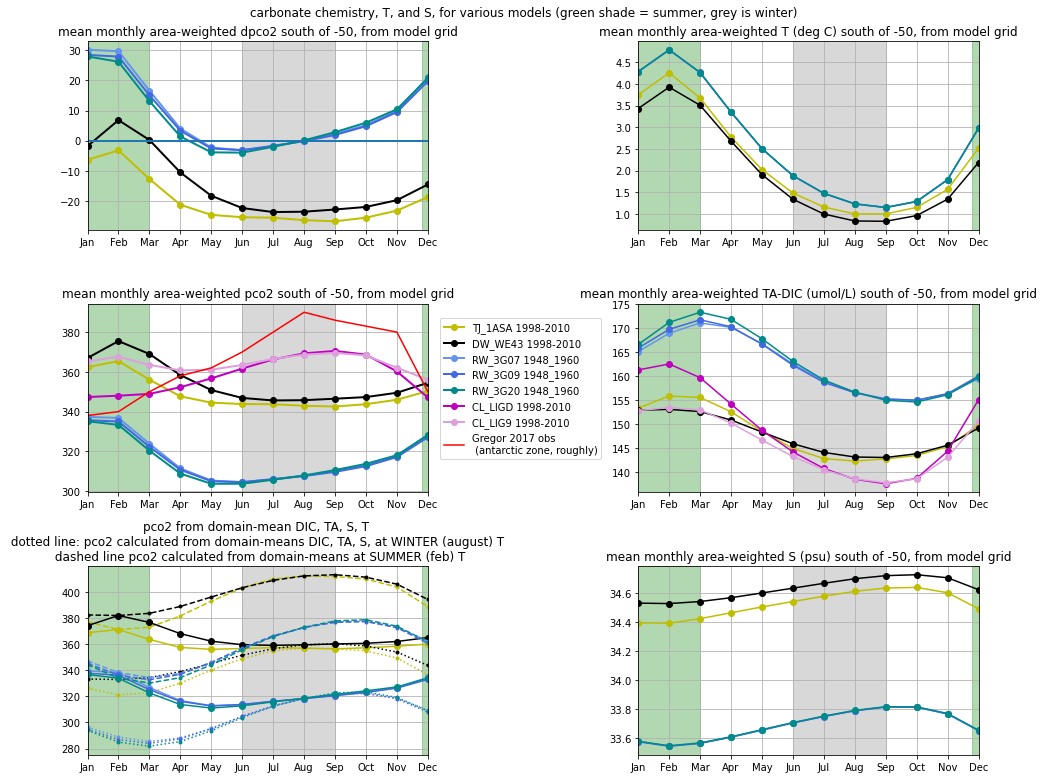

In [18]:
fact = 1.1
fig, axs = plt.subplots(3,2, figsize=(12*fact, 10*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = xr.open_dataset('./ncs/SOsummary_CarbonTS_TOM12_TJ_1ASA_1998_2010.nc'); tcol = 'y'
draw_summarylines(w, 'TJ_1ASA 1998-2010', tcol)
w = xr.open_dataset('./ncs/SOsummary_CarbonTS_TOM12_DW_WE43_1998_2010.nc'); tcol = 'k'
draw_summarylines(w, 'DW_WE43 1998-2010', tcol)
w = xr.open_dataset('./ncs/SOsummary_CarbonTS_TOM12_RW_3G07_1948_1960.nc'); tcol = 'cornflowerblue'
draw_summarylines(w, 'RW_3G07 1948_1960', tcol)
w = xr.open_dataset('./ncs/SOsummary_CarbonTS_TOM12_RW_3G09_1948_1960.nc'); tcol = 'royalblue'
draw_summarylines(w, 'RW_3G09 1948_1960', tcol)
w = xr.open_dataset('./ncs/SOsummary_CarbonTS_TOM12_RW_3G20_1948_1960.nc'); tcol = 'darkcyan'
draw_summarylines(w, 'RW_3G20 1948_1960', tcol)
w = xr.open_dataset('./ncs/SOsummary_CarbonTS_TOM10_CL_LIGD_1998_2010.nc'); tcol = 'm'
draw_summarylines(w, 'CL_LIGD 1998-2010', tcol)
w = xr.open_dataset('./ncs/SOsummary_CarbonTS_TOM10_CL_LIG9_1998_2010.nc'); tcol = 'plum'
draw_summarylines(w, 'CL_LIG9 1998-2010', tcol)
axs[2].plot(mo,pco2_gregor17, color = 'r', label = 'Gregor 2017 obs \n (antarctic zone, roughly)')
for i in range(0,6):
    axs[i].set_xlim([1,12])
    axs[i].set_xticks(np.arange(1,13))
    axs[i].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',\
                           'Jul','Aug','Sep','Oct','Nov','Dec',])
    axs[i].axvspan(1, 3, alpha=0.3, color='green')
    axs[i].axvspan(11.8, 13, alpha=0.3, color='green')
    axs[i].axvspan(6, 9, alpha=0.3, color='grey')
    axs[2].legend(bbox_to_anchor = ([1.02,0.95]))
    axs[0].axhline(y=0)
    axs[i].grid()
axs[0].set_title('mean monthly area-weighted dpco2 south of -50, from model grid')
axs[2].set_title('mean monthly area-weighted pco2 south of -50, from model grid')
axs[1].set_title('mean monthly area-weighted T (deg C) south of -50, from model grid')
axs[3].set_title('mean monthly area-weighted TA-DIC (umol/L) south of -50, from model grid')
axs[4].set_title('pco2 from domain-mean DIC, TA, S, T \n dotted line: pco2 calculated from domain-means DIC, TA, S, at WINTER (august) T \n dashed line pco2 calculated from domain-means at SUMMER (feb) T')
axs[5].set_title('mean monthly area-weighted S (psu) south of -50, from model grid')

plt.suptitle('carbonate chemistry, T, and S, for various models (green shade = summer, grey is winter)')

plt.tight_layout()